In [9]:
import re
import json

In [11]:
with open('data/Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [12]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [13]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

In [14]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [15]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [16]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [22]:
# Input Community to perform analysis on
community_id_to_use = 21212

In [23]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
255     2330757        21212              208   
259     1272065        21212              208   
261      992972        21212              208   
262      832682        21212              208   
404      892911        21212              339   

                                                 title  year  \
255  Energy-aware On-demand Scatternet Formation an...  2007   
259  Distributed MAC Strategy for Exploiting Multi-...  2007   
261  Joint User Scheduling, User Association, and R...  2014   
262  Goodput maximization in opportunistic spectrum...  2012   
404  Blind Transmitter Authentication for Spectrum ...  2014   

                                              abstract  
255  Power-aware routing algorithms aim to extend t...  
259  Fast rate adaptation has been established as a...  
261  This paper investigates the joint optimization...  
262  We consider a cognitive radio scenario where t...  
404  Recent advances in spectrum access technologie...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

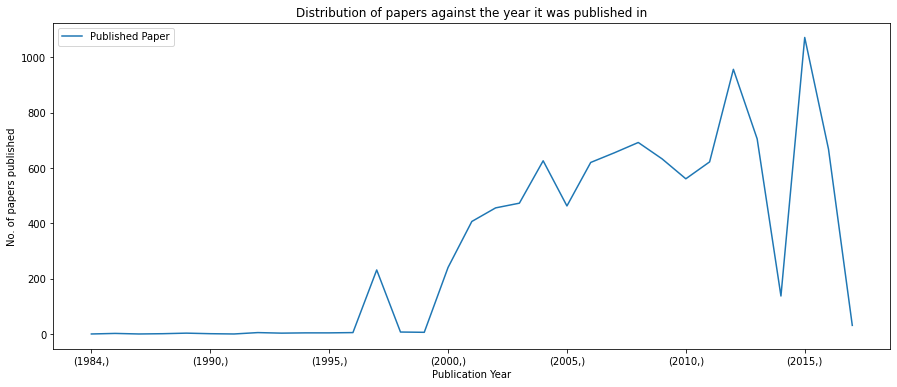

In [24]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2004 with year 2011 accounting for the highest number of papers.

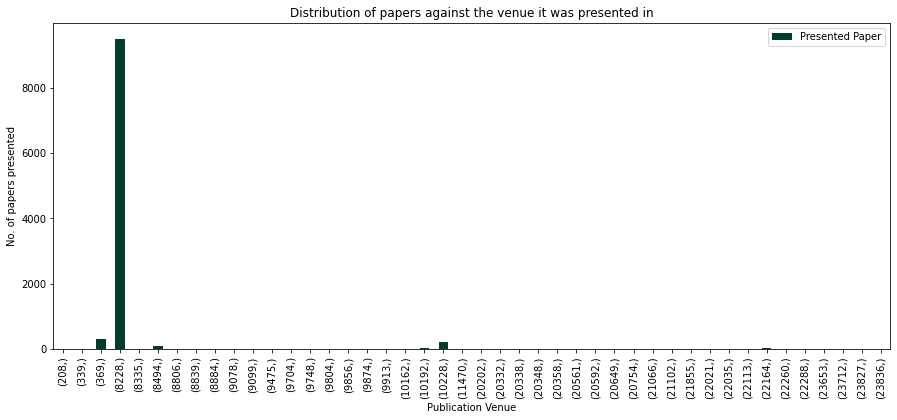

In [25]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [26]:
conference_data_dict[8228]

'international conference on communications'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 23735 which corresponds to the **International Conference on Communications**, Hence most of the papers in the community are from that conference. We should be expecting papers about communications and its related technologies.

In [27]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

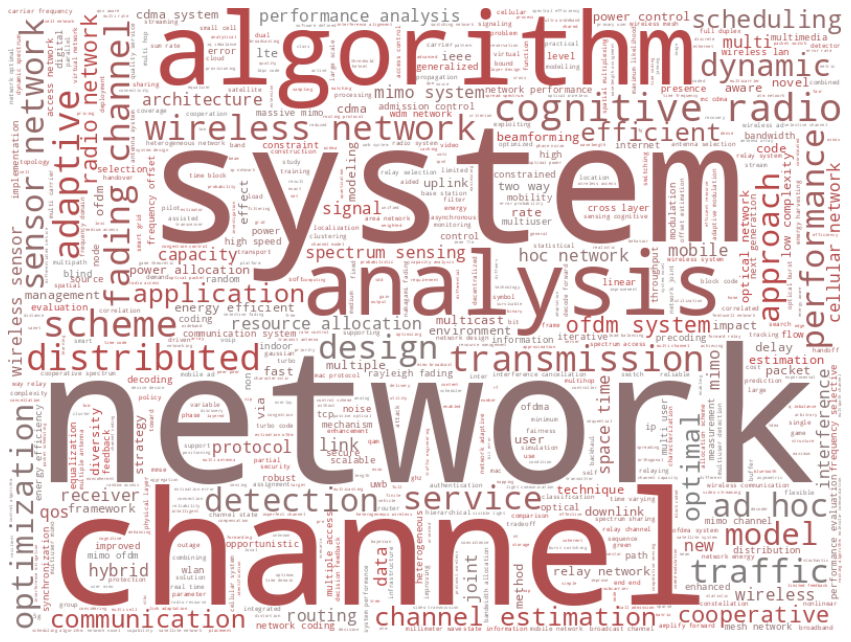

In [28]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on images and videos models and algorithms. Since most papers of the community were presented at a conference about image processing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

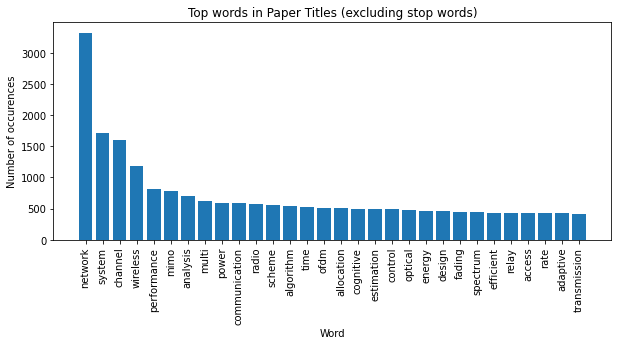

In [29]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are networks, channels, wireless performance and so on. Considering most communications and networks, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [30]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [31]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [32]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [33]:
lda.show_topics(total_topics,6)

[(0,
  '0.037*"system" + 0.025*"multi" + 0.024*"allocation" + 0.024*"bluetooth" + 0.020*"network" + 0.020*"resource"'),
 (1,
  '0.066*"channel" + 0.038*"system" + 0.032*"performance" + 0.030*"mimo" + 0.023*"analysis" + 0.021*"fading"'),
 (2,
  '0.062*"network" + 0.022*"wireless" + 0.021*"packet" + 0.019*"traffic" + 0.019*"qos" + 0.016*"scheduling"'),
 (3,
  '0.032*"network" + 0.028*"system" + 0.026*"wireless" + 0.020*"mimo" + 0.018*"detection" + 0.016*"multicast"'),
 (4,
  '0.031*"time" + 0.027*"network" + 0.027*"code" + 0.026*"space" + 0.019*"communication" + 0.018*"system"'),
 (5,
  '0.071*"network" + 0.039*"sensing" + 0.036*"radio" + 0.035*"cognitive" + 0.034*"wireless" + 0.031*"spectrum"'),
 (6,
  '0.035*"channel" + 0.032*"way" + 0.032*"two" + 0.026*"network" + 0.024*"ofdm" + 0.022*"system"'),
 (7,
  '0.053*"network" + 0.021*"management" + 0.019*"dynamic" + 0.018*"interference" + 0.017*"spectrum" + 0.017*"user"'),
 (8,
  '0.045*"network" + 0.033*"relay" + 0.032*"system" + 0.026*"po

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [34]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

system     multi  allocation  bluetooth   network  resource     ofdma  \
0  0.036947  0.024637    0.024477   0.023805  0.019895  0.019817  0.017565   
1  0.037861  0.007277    0.000000   0.000000  0.008152  0.000000  0.000000   
2  0.000000  0.000000    0.011609   0.000000  0.062152  0.000000  0.000000   
3  0.028443  0.000000    0.000000   0.000000  0.032248  0.000000  0.000000   
4  0.017979  0.000000    0.000000   0.000000  0.027344  0.000000  0.000000   
5  0.000000  0.010950    0.000000   0.000000  0.070926  0.000000  0.000000   
6  0.021661  0.010746    0.000000   0.000000  0.025848  0.000000  0.000000   
7  0.000000  0.000000    0.000000   0.000000  0.052619  0.000000  0.000000   
8  0.032237  0.012630    0.025869   0.000000  0.045007  0.010761  0.000000   
9  0.044663  0.000000    0.000000   0.000000  0.000000  0.000000  0.000000   

     energy  downlink  efficient  ...   amplify  carrier  multiple  selective  \
0  0.015963  0.015067   0.011155  ...  0.000000  0.00000   0.00000   0.000000   
1  0.000000  0.000000   0.000000  ...  0.000000  0.00000   0.00000   0.000000   
2  0.011706  0.000000   0.009072  ...  0.000000  0.00000   0.00000   0.000000   
3  0.000000  0.000000   0.000000  ...  0.000000  0.00000   0.00000   0.000000   
4  0.000000  0.000000   0.000000  ...  0.000000  0.00000   0.00000   0.000000   
5  0.012178  0.000000   0.007109  ...  0.000000  0.00000   0.00000   0.000000   
6  0.000000  0.000000   0.006638  ...  0.000000  0.00000   0.00000   0.000000   
7  0.000000  0.000000   0.000000  ...  0.000000  0.00000   0.00000   0.000000   
8  0.000000  0.000000   0.000000  ...  0.007664  0.00000   0.00000   0.000000   
9  0.000000  0.000000   0.000000  ...  0.000000  0.02135   0.01428   0.013064   

     offset     pilot     cross     layer       low  synchronization  
0  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
1  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
3  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
5  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
6  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
7  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
8  0.000000  0.000000  0.000000  0.000000  0.000000         0.000000  
9  0.011822  0.008992  0.008864  0.007627  0.007219         0.007202  

[10 rows x 147 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


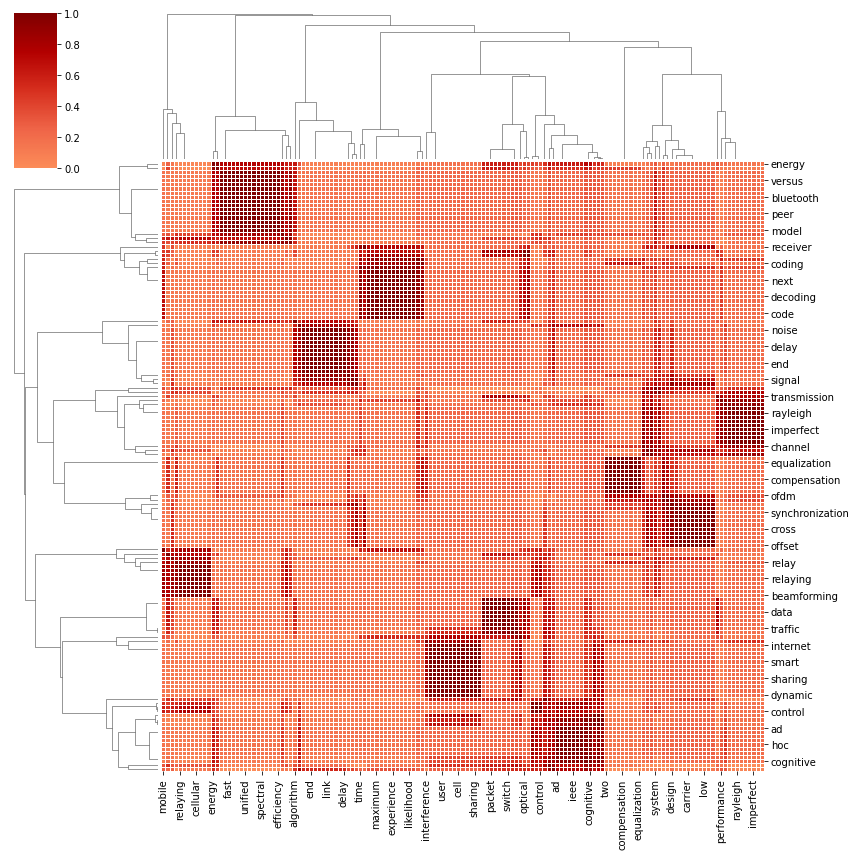

In [35]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [36]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  21.644837
0       0.648955  71.707100       2        1  17.383450
7      71.019684   9.971006       3        1  15.324453
8       3.785981  33.185135       4        1  11.525013
1     -42.666500  -9.222070       5        1   7.332055
4      -3.621689 -43.526516       6        1   6.492095
2      -3.632402  -4.171708       7        1   5.237897
3     -36.584400  35.804413       8        1   5.038077
6      44.391380  50.615383       9        1   5.013670
9      40.235809 -31.591665      10        1   5.008454, topic_info=          Term        Freq       Total Category  logprob  loglift
102    channel  145.000000  145.000000  Default  30.0000  30.0000
94      system  212.000000  212.000000  Default  29.0000  29.0000
37     sensing   91.000000   91.000000  Default  28.0000  28.0000
23     network  421.000000  421.000000  Default  27.0000  27.0000
247      relay   58.000000   58.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
171     signal    3.470812   20.625215  Topic10  -5.0020   1.2119
172   adaptive    3.892004   37.498348  Topic10  -4.8875   0.7287
223  detection    3.410944   42.240143  Topic10  -5.0194   0.4777
114     scheme    3.532766   74.600639  Topic10  -4.9844  -0.0560
213  selection    3.112228   28.958232  Topic10  -5.1111   0.7635

[708 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2411      3  1.016653      '
1145      1  0.323818     's
1145      9  0.647636     's
1778      2  1.026294      1
6         1  0.922057     11
...     ...       ...    ...
370      10  0.045373   wlan
732       2  1.029452  wpans
845       8  0.640924     zf
2599      2  1.043685    ziv
266       9  0.914885     zp

[1354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 8, 9, 2, 5, 3, 4, 7, 10])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [37]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [38]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [39]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  end, speed, high, coordinated, advanced, self, experimental, tcp, point, assessment, similar, terminal, red, wavelet, extension

Paper Titles:
Unlicensed LTE/WiFi coexistence: Is LBT inherently fairer than CSAT?
PacketUsher: A DPDK-based packet I/O engine for commodity PC
High speed LSI processing for the RSA cryptogram
An Algorithm for Adapting RED Parameters to TCP Traffic

****************************************************************************************************
TOPIC 1:
Top Words:  ad, hoc, 802, ieee, 11, bluetooth, wlan, multihop, 16, 11e, network, 15, wireless, lan, throughput

Paper Titles:
Reliable co-existence of 802.15.4e TSCH-based WSN and Wi-Fi in an aircraft cabin
Characterising the Behaviour of IEEE 802.11 Broadcast Transmissions in Ad Hoc Wireless LANs
Effect of Power Randomization on Saturation Throughput of IEEE 802.11 WLAN
Throughput Enhancement of IEEE 802.11e WLAN by Transmission Power Randomization

***********************************

## Analyzing the abstracts of the papers

In [40]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

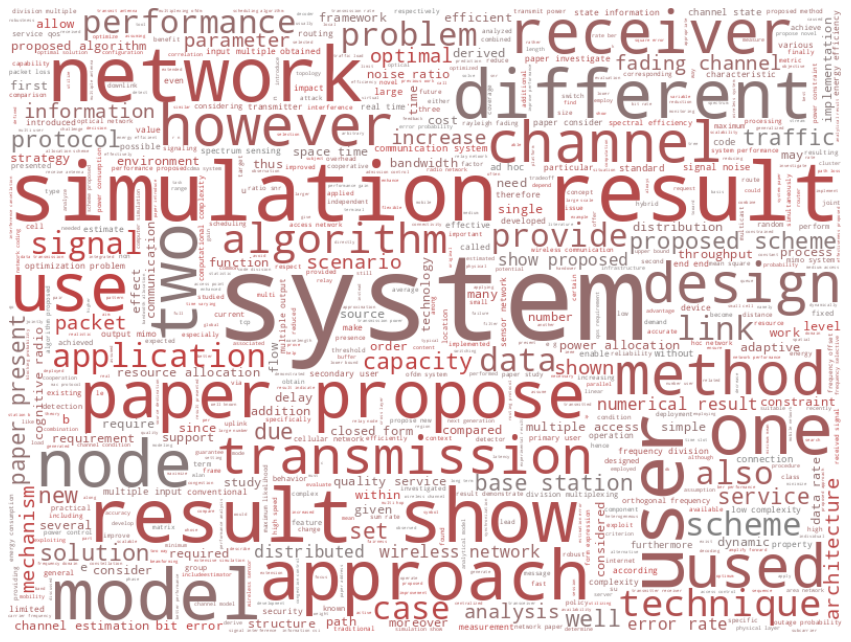

In [41]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [42]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [43]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [44]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [45]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [46]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [47]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [48]:
lda.show_topics(total_topics, 7)

[(0,
  '0.014*"network" + 0.011*"problem" + 0.010*"algorithm" + 0.006*"optimal" + 0.006*"performance" + 0.006*"scheme" + 0.005*"node"'),
 (1,
  '0.028*"network" + 0.009*"system" + 0.006*"algorithm" + 0.006*"performance" + 0.006*"protocol" + 0.005*"model" + 0.005*"node"'),
 (2,
  '0.008*"b" + 0.007*"r n" + 0.005*"channel" + 0.005*"lte u" + 0.004*"bs" + 0.004*"bia scheme" + 0.004*"receiver"'),
 (3,
  '0.008*"network" + 0.006*"application" + 0.006*"proposed" + 0.005*"protocol" + 0.005*"delay" + 0.005*"performance" + 0.005*"ieee 802"'),
 (4,
  '0.014*"system" + 0.012*"sensing" + 0.012*"channel" + 0.011*"cognitive radio" + 0.011*"secondary user" + 0.009*"primary user" + 0.009*"performance"'),
 (5,
  '0.013*"ieee 802" + 0.009*"model" + 0.008*"network" + 0.006*"algorithm" + 0.006*"system" + 0.005*"proposed" + 0.005*"service"'),
 (6,
  '0.019*"channel" + 0.012*"system" + 0.011*"scheme" + 0.011*"performance" + 0.009*"proposed" + 0.007*"rate" + 0.007*"relay"'),
 (7,
  '0.013*"algorithm" + 0.009*

In [49]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

network   problem  algorithm   optimal  performance    scheme      node  \
0  0.014296  0.011277   0.009928  0.006439     0.005798  0.005684  0.005259   
1  0.027787  0.000000   0.006319  0.000000     0.005747  0.004349  0.004845   
2  0.002591  0.000000   0.002592  0.000000     0.002590  0.002939  0.000000   
3  0.007827  0.000000   0.004585  0.000000     0.004731  0.002812  0.000000   
4  0.004179  0.000000   0.004920  0.000000     0.008617  0.007136  0.000000   
5  0.007745  0.003244   0.005699  0.000000     0.003053  0.000000  0.000000   
6  0.000000  0.000000   0.000000  0.003933     0.010927  0.010999  0.000000   
7  0.000000  0.000000   0.013006  0.000000     0.009300  0.003122  0.000000   
8  0.000000  0.000000   0.001987  0.000000     0.001968  0.001694  0.000000   
9  0.008127  0.000000   0.000000  0.000000     0.009837  0.008686  0.000000   

      power      user  approach  ...  generalized decision   max log  \
0  0.004939  0.004831  0.004599  ...              0.000000  0.000000   
1  0.000000  0.004344  0.000000  ...              0.000000  0.000000   
2  0.000000  0.002808  0.000000  ...              0.000000  0.000000   
3  0.000000  0.000000  0.000000  ...              0.000000  0.000000   
4  0.000000  0.003663  0.000000  ...              0.000000  0.000000   
5  0.000000  0.000000  0.002575  ...              0.000000  0.000000   
6  0.000000  0.004745  0.003222  ...              0.000000  0.000000   
7  0.000000  0.000000  0.000000  ...              0.000000  0.000000   
8  0.000000  0.000000  0.000000  ...              0.001758  0.001749   
9  0.003332  0.009683  0.000000  ...              0.000000  0.000000   

   constellation point  due simplicity  capacity  analysis  small cell  \
0             0.000000        0.000000  0.000000  0.000000     0.00000   
1             0.000000        0.000000  0.000000  0.000000     0.00000   
2             0.000000        0.000000  0.000000  0.000000     0.00000   
3             0.000000        0.000000  0.000000  0.000000     0.00000   
4             0.000000        0.000000  0.000000  0.000000     0.00000   
5             0.000000        0.000000  0.000000  0.000000     0.00000   
6             0.000000        0.000000  0.000000  0.000000     0.00000   
7             0.000000        0.000000  0.000000  0.000000     0.00000   
8             0.001658        0.001646  0.000000  0.000000     0.00000   
9             0.000000        0.000000  0.003922  0.003708     0.00367   

   bluetooth      qos      also  
0    0.00000  0.00000  0.000000  
1    0.00000  0.00000  0.000000  
2    0.00000  0.00000  0.000000  
3    0.00000  0.00000  0.000000  
4    0.00000  0.00000  0.000000  
5    0.00000  0.00000  0.000000  
6    0.00000  0.00000  0.000000  
7    0.00000  0.00000  0.000000  
8    0.00000  0.00000  0.000000  
9    0.00337  0.00322  0.002991  

[10 rows x 127 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



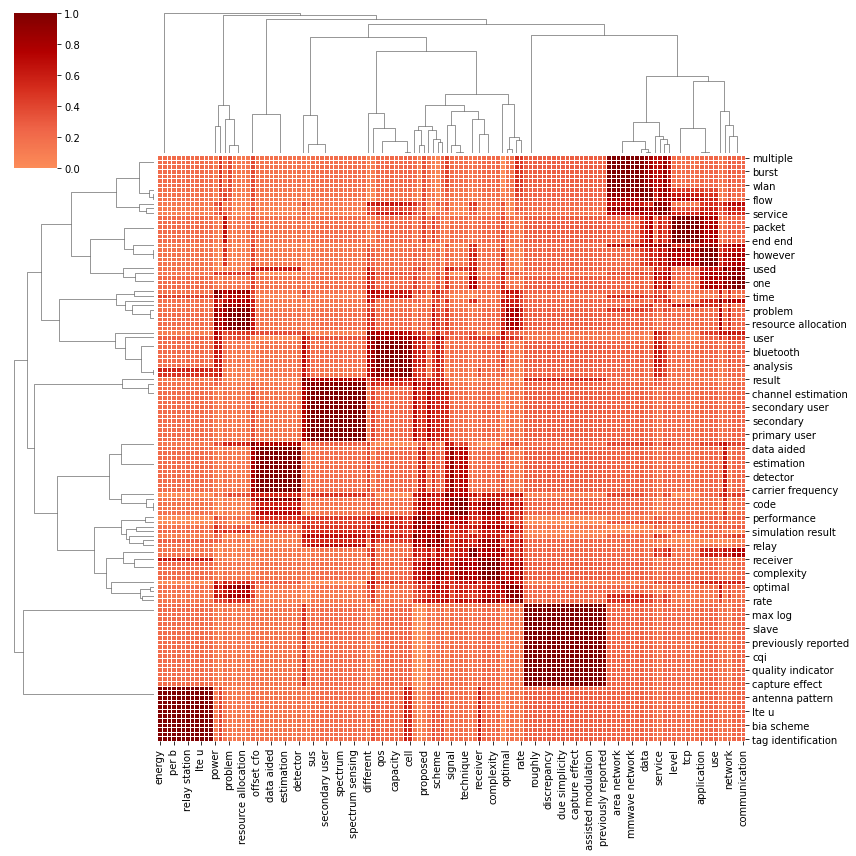

In [50]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [51]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  18.665324
7       0.648955  71.707100       2        1  17.699557
0      71.019684   9.971006       3        1  12.187860
1       3.785981  33.185135       4        1  11.379772
6     -42.666500  -9.222070       5        1   8.381669
9      -3.621689 -43.526516       6        1   6.344474
4      -3.632402  -4.171708       7        1   6.340858
3     -36.584400  35.804413       8        1   6.338450
2      44.391380  50.615383       9        1   6.333142
8      40.235809 -31.591665      10        1   6.328892, topic_info=             Term       Freq      Total Category  logprob  loglift
22        network  83.000000  83.000000  Default  30.0000  30.0000
59        channel  54.000000  54.000000  Default  29.0000  29.0000
85       ieee 802  32.000000  32.000000  Default  28.0000  28.0000
162        system  68.000000  68.000000  Default  27.0000  27.0000
226       sensing  12.000000  12.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
103   performance   1.283926  64.425187  Topic10  -6.2305  -1.1555
303        scheme   1.104589  47.367587  Topic10  -6.3810  -0.9984
636        design   1.064466  21.104700  Topic10  -6.4180  -0.2270
1965    detection   1.026756  19.264984  Topic10  -6.4540  -0.1718
405         paper   1.020670  33.538828  Topic10  -6.4600  -0.7322

[768 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
19521     10  1.178880     109
20391      1  1.050188     11e
15541     10  1.042539   16qam
16099      1  0.826621      77
48         1  0.499560  802 11
...      ...       ...     ...
2910       6  0.174167    wlan
2910       8  0.087083    wlan
2910       9  0.087083    wlan
20725     10  0.868024     wmn
29399      1  1.093147   wpans

[1035 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 1, 2, 7, 10, 5, 4, 3, 9])

In [52]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [53]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [54]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  fbmc oqam, hard scheme, attestation, hermitian form, la solution, snr calculation, equivalent snr calculation, equivalent snr, voip tracking, oqam system, fbmc oqam system, soft scheme, propose asymptotic, propose asymptotic approximation, successive sample

Paper Titles:
Reliable telemetry in white spaces using remote attestation
Remote control of base station antenna systems based on two-dimensional electrically adjustable technology
Collision-Balancing Frequency Hopping in Single-Hop Mobile Ad Hoc Networks
Link Adaptation algorithms over IEEE8O2. 11 WLANs in collision prone channels

****************************************************************************************************
TOPIC 1:
Top Words:  feat, network coding aggregation, coding aggregation, bta, siso mimo detection, plane 10o, angular step, array enabled cdma, offered antenna array, offered rake, reformulate several, spatial diversity offered, receiver operating frequency, offered rake suppressin

In [55]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [56]:
representative_df.to_csv("CSV_files/repr_21212.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
77103     2272818        21212             9856   
10477     2953439        21212             8228   
8274       892438        21212              369   
9470       406052        21212              369   
5032      1995150        21212              369   
...           ...          ...              ...   
10482     2967564        21212             8228   
9715       360256        21212              369   
10452     2990182        21212             8228   
4855      1972984        21212              369   
6400      1657213        21212              369   

                                                   title  year  \
77103  Reliable telemetry in white spaces using remot...  2011   
10477  Remote control of base station antenna systems...  2012   
8274   Collision-Balancing Frequency Hopping in Singl...  2012   
9470   Link Adaptation algorithms over IEEE8O2. 11 WL...  2006   
5032   Iterative (TURBO) IQ Imbalance Estimation and ...  2007   
...                                                  ...   ...   
10482   Interference management in heterogeneous network  2012   
9715   List Stack Detection with Reduced Search Space...  2006   
10452  Field test of uplink CoMP joint processing wit...  2012   
4855   Improved MMSE Vector Precoding Based on the MB...  2009   
6400   Resource Block Assignment for Interference Avo...  2012   

                                                abstract  
77103  We consider reliable telemetry in white spaces...  
10477  The adjustments of vertical angle and horizont...  
8274   We consider a single-hop frequency hopping (FH...  
9470   In this paper the issue of link adaptation (LA...  
5032   TURBO principle has been exploited gainfully t...  
...                                                  ...  
10482  Inter-cell interference is the main factor inf...  
9715   The interest in near-ML detection algorithms f...  
10452  Uplink Coordinated Multi-Point (CoMP) joint pr...  
4855   A novel vector precoding scheme is proposed fo...  
6400   In this paper, we investigate resource block a...  

[787 rows x 6 columns]